# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [39]:
#test solo para validar tanto el numero de tablas como us encabezados:
from bs4 import BeautifulSoup
import requests
import pandas as pd

url = "https://companies-market-cap-copy.vercel.app/index.html"
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

tables = soup.find_all('table')
print(f"Se encontraron {len(tables)} tablas en la página.")

# Recorre cada tabla e imprime sus encabezados
for i, table in enumerate(tables):
    headers = [th.get_text(strip=True) for th in table.find_all("th")]
    print(f"Tabla #{i}: columnas = {headers}")


Se encontraron 2 tablas en la página.
Tabla #0: columnas = ['Year', 'Revenue', 'Change']
Tabla #1: columnas = ['Company', 'Revenue', 'Revenuedifferencediff.', 'Country']


In [45]:
# URL
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

url = "https://companies-market-cap-copy.vercel.app/index.html"

# Realizando la petición GET
response = requests.get(url)

if response.status_code == 200:
    soup = BeautifulSoup(response.text, 'html.parser')

    tables = soup.find_all('table')
    print(f'Se encontraron {len(tables)} tablas en la página')

    # Obteniendo la tabla con la evolución anual de revenue
    table_tesla_revenue = tables[0]

    # Extracción de datos
    encabezados = [header.get_text(strip=True) for header in table_tesla_revenue.find_all("th")]

    filas = []
    for row in table_tesla_revenue.find_all("tr")[1:]:  # Omite la fila de encabezado
        columnas = row.find_all("td")
        if len(columnas) == len(encabezados):  # Verifica que coincidan columnas y encabezados
            datos_fila = [col.get_text(strip=True) for col in columnas]
            filas.append(datos_fila)

    # Creación del DataFrame
    df_anual = pd.DataFrame(filas, columns=encabezados)
   # print(df_anual)
else:
    print(f"Error al acceder a la página: {response.status_code}")

#paso#4 Procesando el DF:
#Por seguirdad copio el DF original:
copy_df_annual=df_anual
#Eliminar filas vacías o nulas en cualquiera de las columnas importantes
copy_df_annual.dropna(subset=['Year', 'Revenue', 'Change'], inplace=True)
#Quitar símbolos $ y la letra B de la columna 'Revenue'

copy_df_annual['Revenue'] =(
    copy_df_annual['Revenue']
    .str.replace('$','', regex=False)
    .str.replace('B', '', regex=False)
    .str.strip()    
)
#Convirtiendo el campo revenue a valor numerico(Float):
copy_df_annual['Revenue']=pd.to_numeric(copy_df_annual['Revenue'],errors='coerce')
#AGORA Eliminando filas Nan creadas por la conversion:
copy_df_annual.dropna(subset=['Revenue'],inplace=True)

print(copy_df_annual)

#Almacenando los datos en una bd:
connection= sqlite3.connect('tesla_revenue.db')
cursor= connection.cursor()

create_table_query= '''\
CREATE TABLE IF NOT EXISTS TeslaAnnualRevenue(
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    Year TEXT,
    Revenue REAL,
    Change TEXT
)        
    '''
cursor.execute(create_table_query)

cursor.execute('DELETE FROM TeslaAnnualRevenue')

for index, row in copy_df_annual.iterrows():
        year = row['Year']
        revenue = row['Revenue']
        change = row['Change']
        insert_query = "INSERT INTO TeslaAnnualRevenue (Year, Revenue, Change) VALUES (?, ?, ?)"
        cursor.execute(insert_query, (year, revenue, change))

    # 5.4 Guardar cambios
connection.commit()
print("\nDatos insertados en SQLite correctamente.")

Se encontraron 2 tablas en la página
    Year  Revenue   Change
0   2024    97.15    0.39%
1   2023    96.77    18.8%
2   2022    81.46   51.35%
3   2021    53.82   70.67%
4   2020    31.53   28.31%
5   2019    24.57   14.52%
6   2018    21.46   82.51%
7   2017    11.75   67.98%
8   2016     7.00   73.01%
9   2015     4.04    26.5%
10  2014     3.19   58.85%
11  2013     2.01  387.23%
12  2012     0.41  102.34%
13  2011     0.20   74.95%
14  2010     0.11    4.29%
15  2009     0.11         

Datos insertados en SQLite correctamente.


In [46]:
# Verificar datos insertados
select_query = "SELECT * FROM TeslaAnnualRevenue"
cursor.execute(select_query)
rows = cursor.fetchall()

print("\nContenido en la tabla TeslaAnnualRevenue:")
for row in rows:
    print(row)



Contenido en la tabla TeslaAnnualRevenue:
(1, '2024', 97.15, '0.39%')
(2, '2023', 96.77, '18.8%')
(3, '2022', 81.46, '51.35%')
(4, '2021', 53.82, '70.67%')
(5, '2020', 31.53, '28.31%')
(6, '2019', 24.57, '14.52%')
(7, '2018', 21.46, '82.51%')
(8, '2017', 11.75, '67.98%')
(9, '2016', 7.0, '73.01%')
(10, '2015', 4.04, '26.5%')
(11, '2014', 3.19, '58.85%')
(12, '2013', 2.01, '387.23%')
(13, '2012', 0.41, '102.34%')
(14, '2011', 0.2, '74.95%')
(15, '2010', 0.11, '4.29%')
(16, '2009', 0.11, '')


In [47]:
# 1) Confirmamos que se guardó
connection.commit()
print("\nDatos insertados en SQLite correctamente.")

# 2) Leer la tabla en un DataFrame usando read_sql_query
df_sqlite = pd.read_sql_query("SELECT * FROM TeslaAnnualRevenue", connection)

# 3) Imprimir en formato tabular con cabeceras
print("\nContenido de la tabla TeslaAnnualRevenue (con encabezados):\n", df_sqlite)

# 4) Cerrar conexión
connection.close()



Datos insertados en SQLite correctamente.

Contenido de la tabla TeslaAnnualRevenue (con encabezados):
     id  Year  Revenue   Change
0    1  2024    97.15    0.39%
1    2  2023    96.77    18.8%
2    3  2022    81.46   51.35%
3    4  2021    53.82   70.67%
4    5  2020    31.53   28.31%
5    6  2019    24.57   14.52%
6    7  2018    21.46   82.51%
7    8  2017    11.75   67.98%
8    9  2016     7.00   73.01%
9   10  2015     4.04    26.5%
10  11  2014     3.19   58.85%
11  12  2013     2.01  387.23%
12  13  2012     0.41  102.34%
13  14  2011     0.20   74.95%
14  15  2010     0.11    4.29%
15  16  2009     0.11         


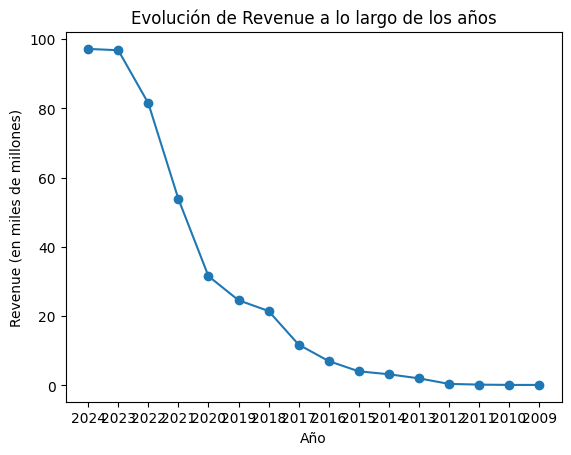

In [48]:
'''
Paso 6: Visualiza los datos
¿Qué tipos de visualizaciones podemos realizar? Propón al menos 3 y muéstralos.
'''
# Gráfico 1: Evolución de Revenue a lo largo de los años (Line Plot)
plt.figure()
plt.plot(copy_df_annual['Year'], copy_df_annual['Revenue'], marker='o')
plt.title("Evolución de Revenue a lo largo de los años")
plt.xlabel("Año")
plt.ylabel("Revenue (en miles de millones)")
plt.show()


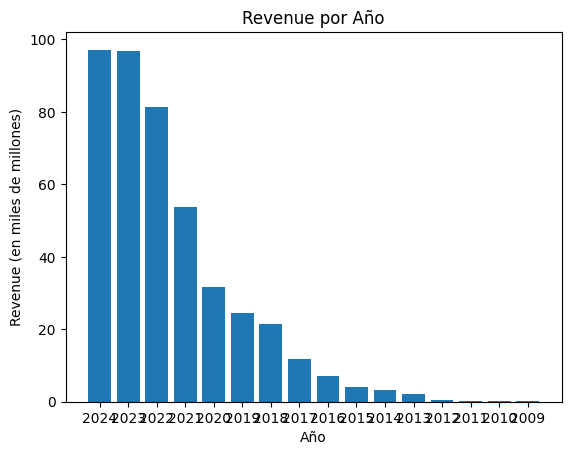

In [49]:
# Gráfico 2: Comparación de Revenue por año (Bar Plot)
plt.figure()
plt.bar(copy_df_annual['Year'], copy_df_annual['Revenue'])
plt.title("Revenue por Año")
plt.xlabel("Año")
plt.ylabel("Revenue (en miles de millones)")
plt.show()

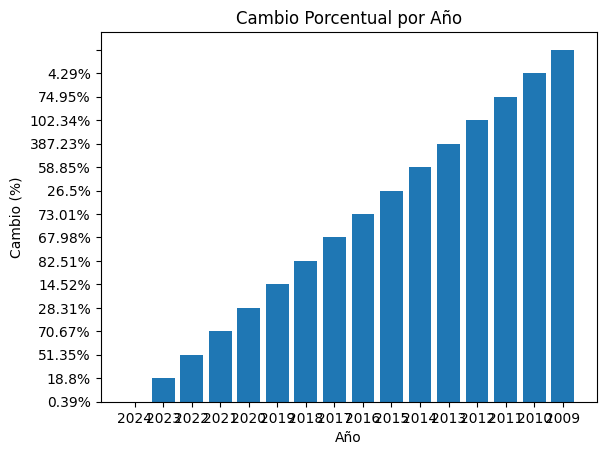

In [50]:
# Gráfico 3: Cambio porcentual por año (Bar Plot)
plt.figure()
plt.bar(copy_df_annual['Year'], copy_df_annual['Change'])
plt.title("Cambio Porcentual por Año")
plt.xlabel("Año")
plt.ylabel("Cambio (%)")
plt.show()

In [ ]:
 # Cerrar conexión con la BD
connection.close()